# Regression with truncated or censored data

The notebook provides an example of how to conduct linear regression when your outcome variable is either censored or truncated.

**Author:** [Ben Vincent](https://github.com/drbenvincent)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf
import arviz as az
from copy import copy

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.10.0


In [2]:
%config InlineBackend.figure_format = 'retina'

## Truncation and censoring are part of the data generating process

Truncation and censoring examples of missing data problems. It can sometimes be easy to muddle up truncation and censoring, so let's look at some definitions.
 
- **Truncation** is a type of missing data problem where you are simply unaware of any data that falls outside of a certain set of bounds.
- **Censoring** occurs when a measurement has a sensitivity with a certain set of bounds. But rather than discard data outside these bounds, you would record a measurement at the bound which it exceeded.

Let's further explore this with some code and plots. First we will generate some true `(x, y)` scatter data, where `y` is our outcome measure and `x` is some predictor variable.

In [3]:
m, c, σ, N = 1, 0, 2, 200
x = np.random.uniform(-10, 10, N)
y = np.random.normal(m * x + c, σ)

For this example of `(x, y)` scatter data, we can describe the truncation process as simply filtering out any data for which our outcome variable `y` falls outside of a set of bounds.

In [4]:
def truncate_y(x, y, bounds):
    keep = (y >= bounds[0]) & (y <= bounds[1])
    return (x[keep], y[keep])

With censoring however, we are setting the `y` value equal to the bounds that they exceed.

In [5]:
def censor_y(x, y, bounds):
    cy = copy(y)
    cy[y<=bounds[0]] = bounds[0]
    cy[y>=bounds[1]] = bounds[1]
    return (x, cy)

Based on our generated `(x, y)` data (which an experimenter would never see in real life), we can generate our actual observed datasets for truncated data `(xt, yt)` and censored data `(xc, yc)`.

In [6]:
bounds = [-5, 5]
xt, yt = truncate_y(x, y, bounds)
xc, yc = censor_y(x, y, bounds)

We can visualise this latent data (in grey) and the remaining truncated or censored data (black) as below.

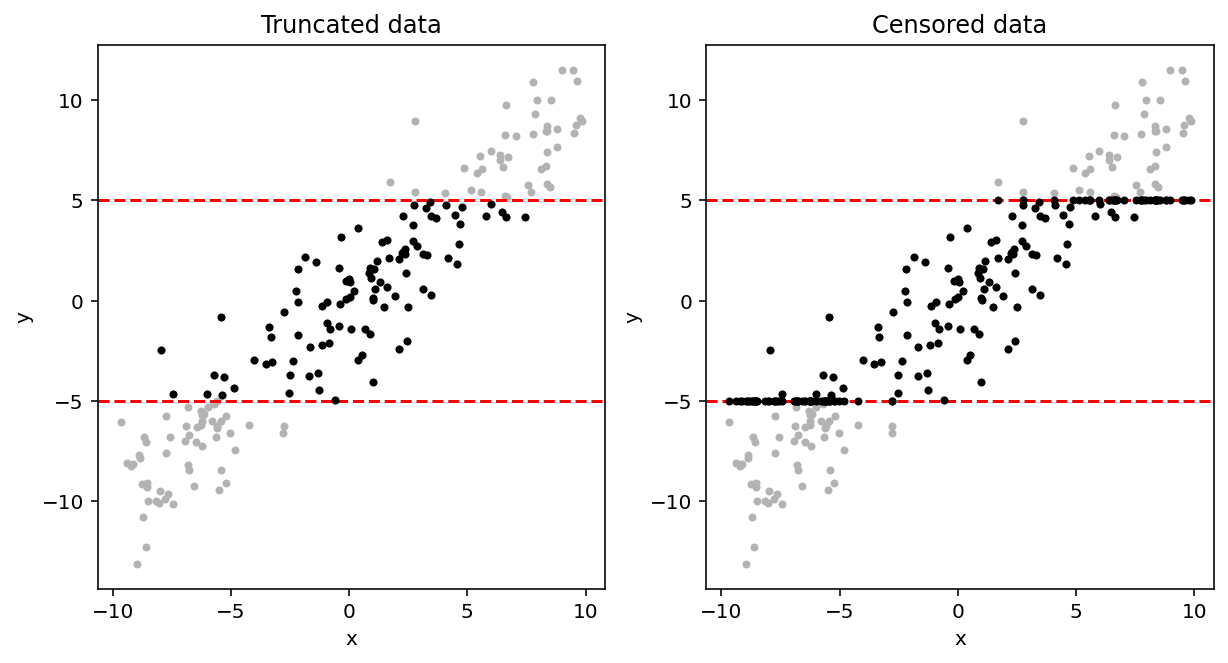

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for ax in axes:
    ax.plot(x, y, '.', c=[0.7, 0.7, 0.7])
    ax.axhline(bounds[0], c='r', ls='--')
    ax.axhline(bounds[1], c='r', ls='--')
    ax.set(xlabel="x", ylabel="y")

axes[0].plot(xt, yt, '.', c=[0, 0, 0])
axes[0].set(title="Truncated data")

axes[1].plot(xc, yc, '.', c=[0, 0, 0])
axes[1].set(title="Censored data");

## The problem that truncated or censored regression solves
If we were to run regular linear regression on either the truncated or censored data, it should be fairly intuitive to see that we will likely overestimate the slope. Truncated regression and censored regress (aka Tobit regression) were designed to address these missing data problems and hopefully result in regression slopes which are free from the bias introduced by truncation or censoring.

In this section we will run Bayesian linear regresion on these datasets to see the extent of the problem. We start by defining a function which defines a PyMC3 model, conducts MCMC sampling, and returns the model and the MCMC chain (often called the trace).

In [8]:
def linear_regression(x, y):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m*x+c, sd=σ, observed=y)

    with model:
        trace = pm.sample()

    return model, trace

So we can run this on our truncated and our censored data, seperately.

In [9]:
trunc_linear_model, trunc_linear_trace = linear_regression(xt, yt)

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [10]:
cens_linear_model, cens_linear_trace = linear_regression(xc, yc)

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, c, m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


By plotting the posterior distribution over the slope parameters we can see that the estimates for `m` are pretty far off, so we are indeed underestimating the regression slope.

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


[Text(0.5, 1.0, 'Linear regression\n(censored data)'), Text(0.5, 0, 'm')]

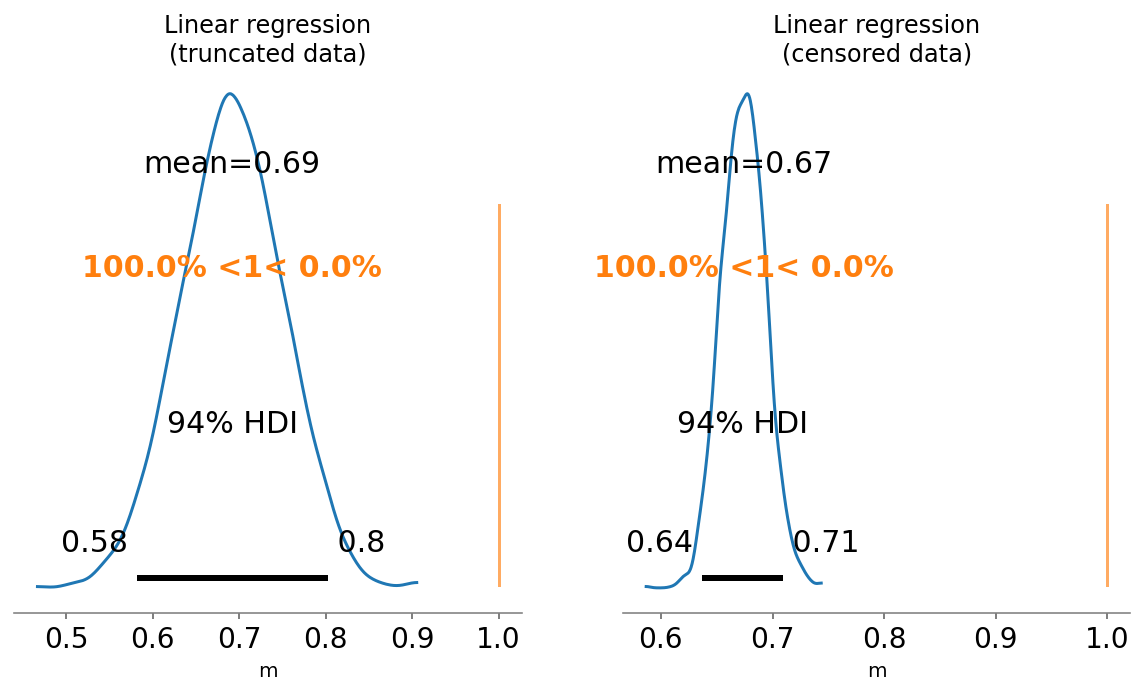

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

az.plot_posterior(trunc_linear_trace, var_names=['m'], ref_val=m, ax=ax[0])
ax[0].set(title="Linear regression\n(truncated data)", xlabel="m")

az.plot_posterior(cens_linear_trace, var_names=['m'], ref_val=m, ax=ax[1])
ax[1].set(title="Linear regression\n(censored data)", xlabel="m")

To appreciate the extent of the problem (for this dataset) we can visualise the posterior predictive fits alongside the data.

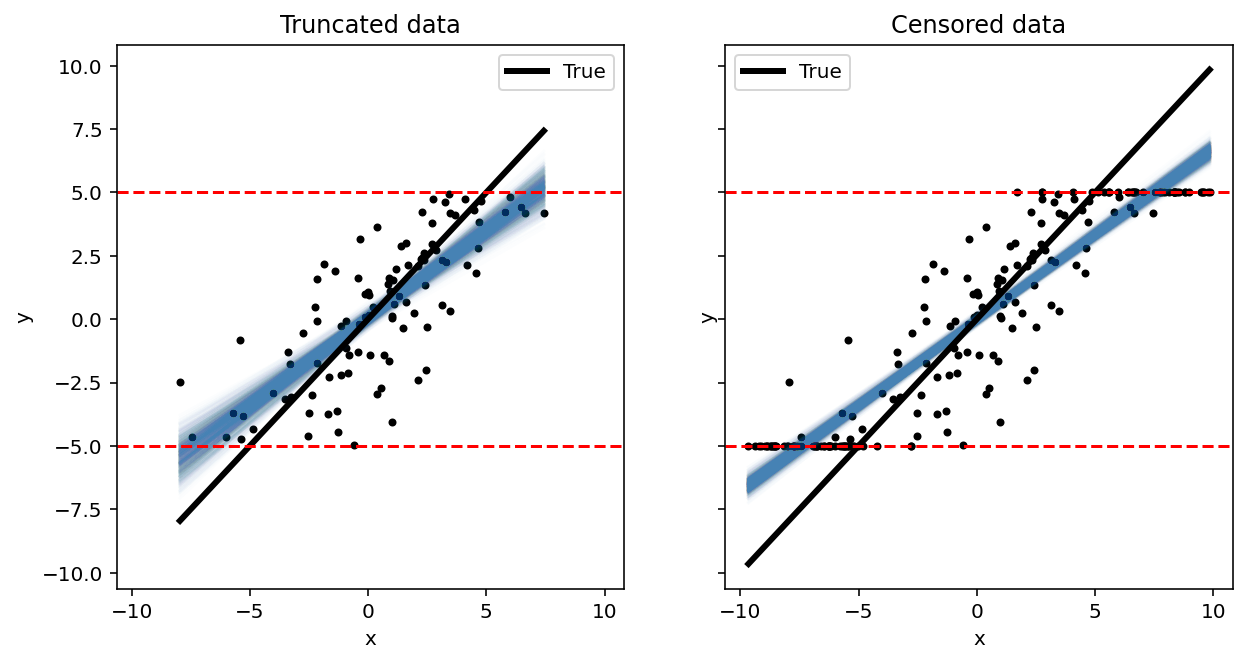

In [12]:
def pp_plot(x, y, trace, ax):
    # plot data
    ax.plot(x, y, 'k.')
    # plot posterior predicted... samples from posterior
    xi = np.array([np.min(x), np.max(x)])
    n_samples=1000
    for n in range(n_samples):
        y_ppc = xi * trace["m"][n] + trace["c"][n]
        ax.plot(xi, y_ppc, c="steelblue", alpha=0.01, rasterized=True)
    # plot true
    ax.plot(xi, m * xi + c, "k", lw=3, label="True")
    # plot bounds
    ax.axhline(bounds[0], c='r', ls='--')
    ax.axhline(bounds[1], c='r', ls='--')
    ax.legend()
    ax.set(xlabel="x", ylabel="y")

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pp_plot(xt, yt, trunc_linear_trace, ax[0])
ax[0].set(title="Truncated data")

pp_plot(xc, yc, cens_linear_trace, ax[1])
ax[1].set(title="Censored data");

## Implimenting truncated and censored regression models
Now we have seen the problem of conducting regression on truncated or censored data, in terms of underestimating the regression slopes. This is what truncated or censored regression models were designed to avoid. The general approach taken by both truncated and censored regression is to encode our prior knowledge of the truncation or censoring steps in the data generating process. This is done by modifying the likelihood function in various ways.

### Truncated regresison model
Truncated regression models are quite simple to impliment. The normal likelihood is centered on the regression slope as normal, but now we just specify a normal distribution which is truncated at the bounds.

In [13]:
def truncated_regression(x, y, bounds):

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)

        y_likelihood = pm.TruncatedNormal(
            "y_likelihood",
            mu=m * x + c,
            sd=σ,
            observed=y,
            lower=bounds[0],
            upper=bounds[1],
        )
    
    with model:
        trace = pm.sample()

    return model, trace

### Censored regression model
Implimenting the censored regression model is a little more involved, but not much so. First there is some data pre-processing. This takes in the raw data and splits it into 3 seperate groups based upon left/lower censoring, uncensored, or right/upper censoring. Each of these groups have their own likelihood.
- The likelihood of lower censored data is set at the area to the left of the lower bound.
- Uncensored data is dealt with using a regular normal likelihood function.
- The likelihood of the upper censored data is set as the area to the right of the upper bound.

In [14]:
def censored_regression(x, y, bounds):
    
    # data pre-processing
    left_censored = (y <= bounds[0])
    x_lc = x[left_censored]
    y_lc = y[left_censored]
    
    right_censored = (y >= bounds[1])
    x_rc = x[right_censored]
    y_rc = y[right_censored]
    
    uncensored = (y>bounds[0]) & (y<bounds[1])
    x = x[uncensored]
    y = y[uncensored]

    with pm.Model() as model:
        m = pm.Normal("m", mu=0, sd=1)
        c = pm.Normal("c", mu=0, sd=1)
        σ = pm.HalfNormal("σ", sd=1)
        y_likelihood = pm.Normal("y_likelihood", mu=m * x + c, sd=σ, observed=y)
        left_censored = pm.Potential("left_censored", normal_lcdf(m * x_lc + c, σ, y_lc))
        right_censored = pm.Potential("right_censored", normal_lccdf(m * x_rc + c, σ, y_rc))

    with model:
        trace = pm.sample()

    return model, trace

Now we can conduct our parameter estimation with the truncated regression model on the truncated data...

In [15]:
truncated_model, truncated_trace = truncated_regression(xt, yt, bounds)

WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tens

and with the censored regression model on the censored data.

In [16]:
censored_model, censored_trace = censored_regression(xc, yc, bounds)

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNIN

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


We can do the same as before and visualise our posterior estimates on the slope `m`.

/Users/benjamv/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
WARNING (theano.tensor.opt): The Op erfcx does not provide a C implement

[Text(0.5, 1.0, 'Censored regression\n(censored data)'), Text(0.5, 0, 'm')]

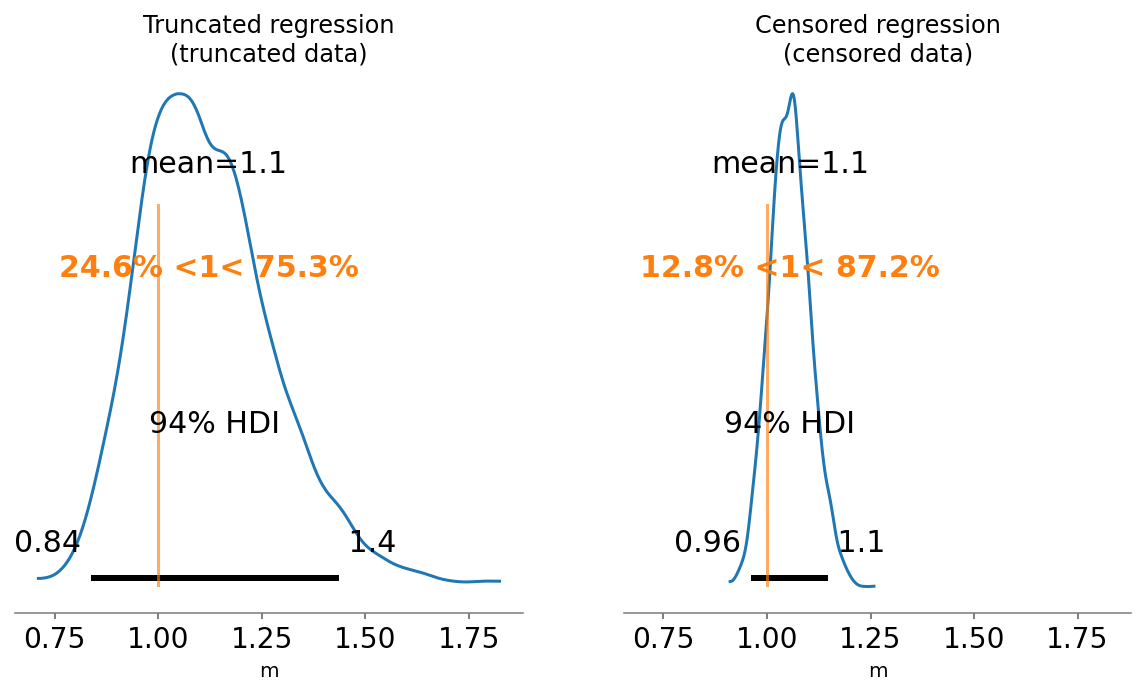

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

az.plot_posterior(truncated_trace, var_names=['m'], ref_val=m, ax=ax[0])
ax[0].set(title="Truncated regression\n(truncated data)", xlabel="m")

az.plot_posterior(censored_trace, var_names=['m'], ref_val=m, ax=ax[1])
ax[1].set(title="Censored regression\n(censored data)", xlabel="m")

These are _much_ better estimates. Interestingly, we can see that the estimate for censored regression is more precise than for truncated data. This will not necessarily always be the case, but the intuition here is that the `x` and `y` data is entirely discarded with truncation, but only the `y` data becomes partially unknown in censoring.

We could speculate then, that if an experimenter had the choice of truncating or censoring data, it might be better to opt for censoring over truncation.

Correspondingly, we can confirm the models are good through visual inspection of the posterior predictive plots.

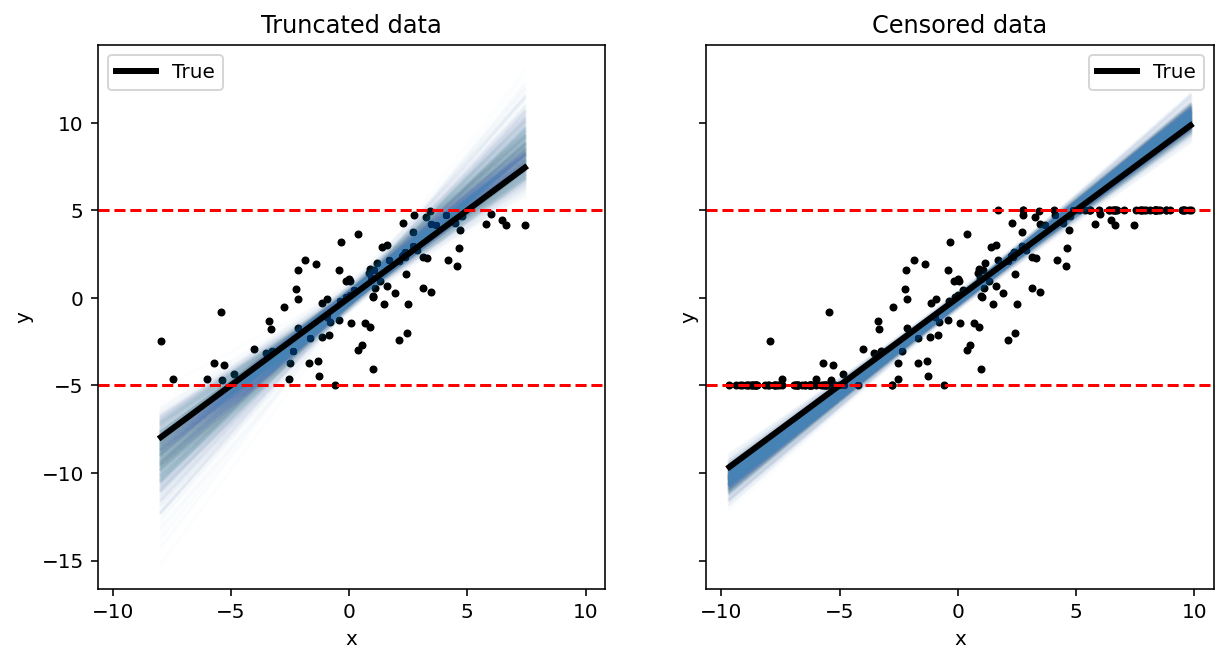

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

pp_plot(xt, yt, truncated_trace, ax[0])
ax[0].set(title="Truncated data")

pp_plot(xc, yc, censored_trace, ax[1])
ax[1].set(title="Censored data");

Hopefully this has been a useful introductory guide to truncated and censored data, and how to build truncated and censored regression models in PyMC3. While the extent of the regression slope estimation bias will vary with a number of factors, hopefully these examples have convinced you of the importance of encoding your knowledge of the data generating process into regression analyses.

In [19]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Jan 25 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy     : 1.19.2
pymc3     : 3.10.0
matplotlib: 3.3.2
arviz     : 0.11.0

Watermark: 2.1.0

